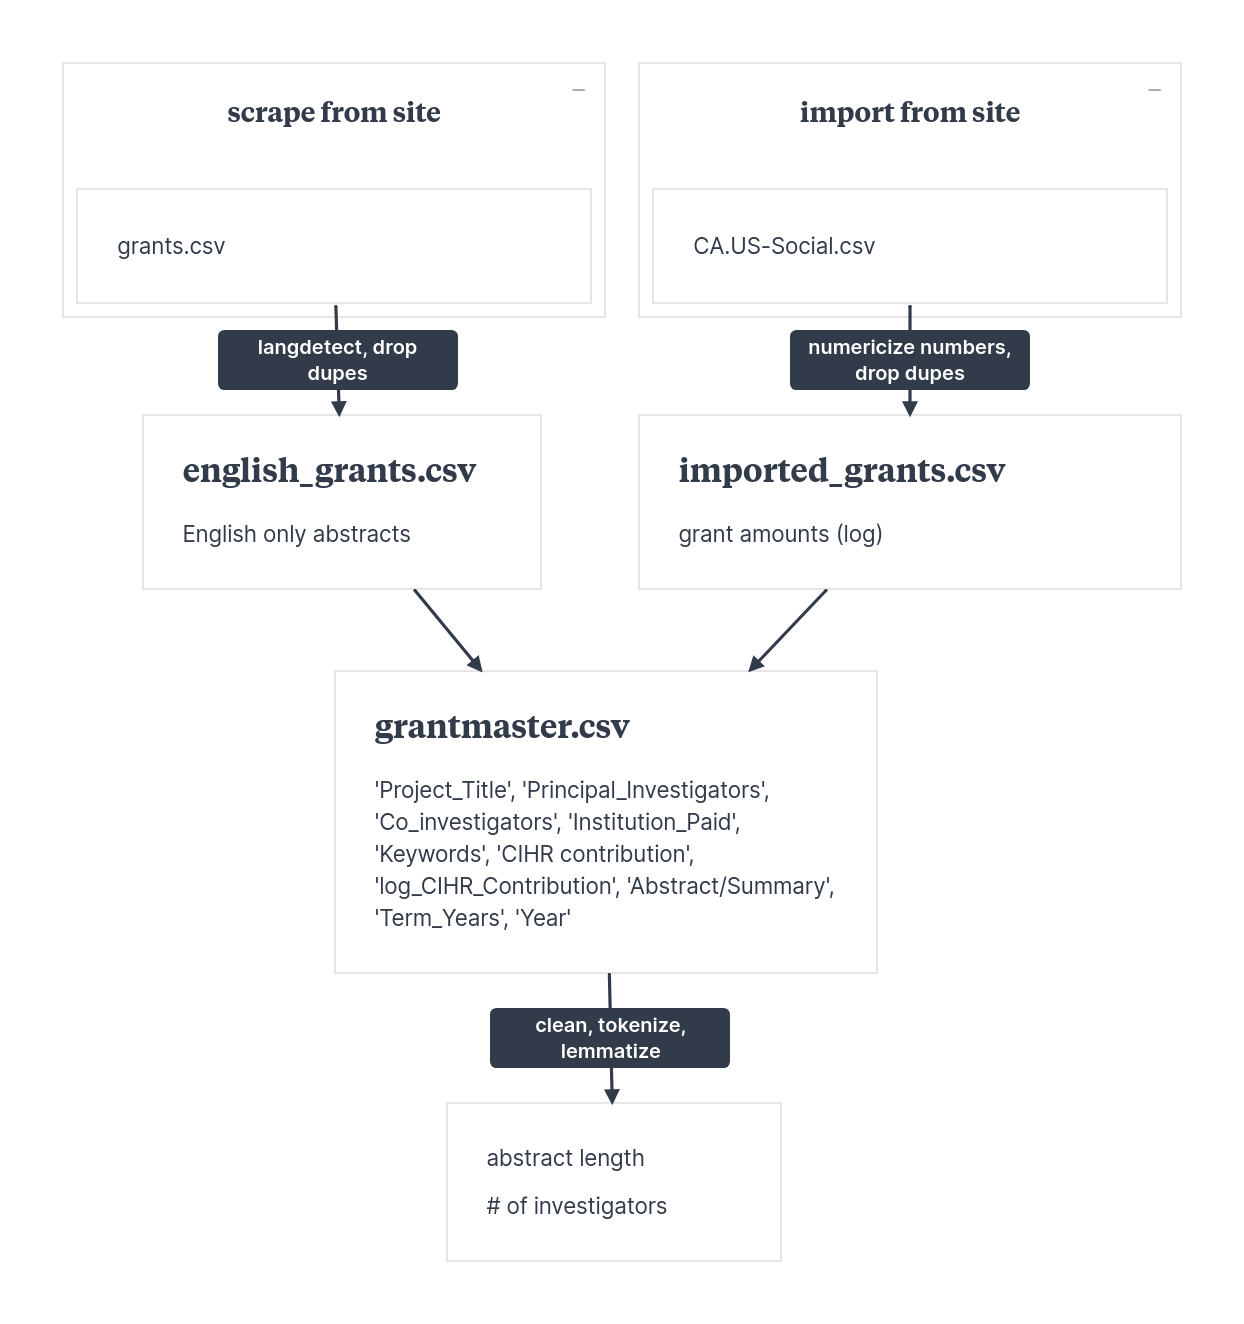

In [25]:
from IPython.display import display, Image
display(Image(filename="images/code script plan.png", width=600))

# 1.0 Data Scraping Script

Import date of raw data file `CA.US-Social.csv`:  2024-11-17

Source:  https://webapps.cihr-irsc.gc.ca/decisions/p/main.html?lang=en#fq={!tag=theme2}theme2%3A%22Social%20%2F%20Cultural%20%2F%20Environmental%20%2F%20Population%20Health%22&fq={!tag=country}country%3ACanada%20%20%20OR%20%20%20country%3A%22United%20States%20of%20America%22&sort=namesort%20asc&start=0&rows=20

## 1.1 Importing

In [11]:
# installations
## section 1.1
import pandas as pd

## section 1.2
from bs4 import BeautifulSoup
import csv
import numpy as np
import random
import re
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
import time

## section 1.3
import os

## 1.2 Scraping Data

So the search results from which I imported the data contains links to the information on the papers.  Within these links, the abstracts can be found, so once we can scrape that we're golden.

Result:  grants.csv

Issues:
- search results are split into 352 pages, with 20 results per page
- the links to the papers are independent of their positions on the search results

Link structure of search results:

`https://webapps.cihr-irsc.gc.ca/decisions/p/main.html?lang=en#fq={!tag=theme2}theme2%3A%22Social%20%2F%20Cultural%20%2F%20Environmental%20%2F%20Population%20Health%22&fq={!tag=country}country%3ACanada%20%20%20OR%20%20%20country%3A%22United%20States%20of%20America%22&sort=namesort%20asc&start=`**0**`&rows=20` where `row` is a multiple of 20.  The maximum n should be the  max possible integer that satisfies 20n < [count of grants] 



Link structure of papers:

`https://webapps.cihr-irsc.gc.ca/decisions/p/project_details.html?applId=`**462354**`&lang=en` where the `applID` is unique to each paper.

Steps:
1. download chromedriver here https://storage.googleapis.com/chrome-for-testing-public/131.0.6778.69/win64/chromedriver-win64.zip and extract.  The extract location will differ based on operating system (Windows or Mac)
2. initialize driver for selenium.  This step is required since the site is dynamically loaded
3. load and scrape the `applID`s of all n pages of the search result
    
    a. save to `data/applids.csv`
4. use the `applID` to obtain the soup for each grant
5. round 1 of obtaining the abstract, project name, researcher(s) names, contribution count from the soup
6. round 2 of obtaining stuff, since some of the webscraping failed
7. round 3 of obtaining stuff aghhhhh
8. merge everything from grants_scraped1, 2, 3... into one df

### 1.2.1 Scraping applIDs

This shit took 27 mins to run.  Don't run this section again unless necessary LUL

In [ ]:
# Calculate number of pages
if grant_count % 20 == 0:
    page_count = grant_count // 20  # No extra page needed if divisible by 20
else:
    page_count = grant_count // 20 + 1  # Add one more page if not divisible by 20

print(f"Total pages to scrape: {page_count}")

In [ ]:
# Set up Selenium WebDriver with the correct path
options = Options()
options.add_argument('--headless')
service = Service("C:/chromedriver-win64/chromedriver.exe")
driver = webdriver.Chrome(service=service, options=options)

In [ ]:
applids = []

for page_num in range(page_count):
    try:
        start = str(page_num * 20)
        link = 'https://webapps.cihr-irsc.gc.ca/decisions/p/main.html?lang=en#fq={!tag=theme2}theme2%3A%22Social%20%2F%20Cultural%20%2F%20Environmental%20%2F%20Population%20Health%22&fq={!tag=country}country%3ACanada%20%20%20OR%20%20%20country%3A%22United%20States%20of%20America%22&sort=namesort%20asc&start=' + start + '&rows=20'
        driver.get(link)
        driver.implicitly_wait(15)
        html = driver.page_source
        soup = BeautifulSoup(html, 'html.parser')
        links = soup.find_all('a', class_='pull-left')
        for link in links:
            href = link.get('href', '')
            match = re.search(r'applId=(\d+)', href)
            # lang = re.search(r'lang=(\d+)', href)
            if match:
                applids.append(match.group(1))
        # Add a delay between requests to avoid overloading the server and getting my ass banned
        delay = random.uniform(3, 6)
        time.sleep(delay)
    except Exception as e:
        print(f"Error occurred on page {page_num}. Error details: {str(e)}")
        break

In [ ]:
driver.quit()

with open('data/applids.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['applId'])  # Write header
    for applid in applids:
        writer.writerow([applid])

### 1.2.2 Scraping everything else

In [2]:
# initialize and prepare stuff
grants_info = pd.read_csv("data/applids.csv")
grants_applIDs = grants_info['applId'].to_list()

# Set up Selenium WebDriver with the correct path
options = Options()
options.add_argument('--headless')
service = Service("C:/chromedriver-win64/chromedriver.exe")
driver = webdriver.Chrome(service=service, options=options)

In [3]:
# define functions
def extract_info(dl):
    data = {}
    items = dl.find_all(["dt", "dd"])
    for i in range(0, len(items), 2):  # Iterate in pairs of dt and dd
        label = items[i].get_text(strip=True).replace(":", "")
        value = items[i + 1].get_text(strip=True)
        data[label] = value
    return data

def clean_contribution(data):
    contribution_str = data['CIHR contribution']
    if isinstance(contribution_str, str):
        match = re.search(r'Amount:\$(\d{1,3}(?:,\d{3})*)', contribution_str)
        if match:
            data['CIHR contribution'] = float(match.group(1).replace(',', ''))
        else:
            data['CIHR contribution'] = None
    else:
        pass

def convert_to_list_of_strings(data, key):
    # Check if the value for the given key is a string
    if isinstance(data.get(key), str):
        # Split the string by semicolon and remove extra spaces
        data[key] = [name.strip() for name in data[key].split(';')]

In [4]:
# define other shit
grants_scraped = pd.DataFrame(columns=["Project title", "Principal investigator(s)", "Co-investigator(s)", "Keywords", "CIHR contribution", "ApplID"])

keys_to_remove = ['Supervisors', 'Institution paid', 'Research institution', 'Department', 'External applicant partner(s)', 'Program', 'Competition (year/month)', 
                  'Assigned peer review committee', 'Primary institute', 'Primary theme', 'Term (yrs/mths)', 'Contributors', 'Amount', 'Equipment', 'External funding partner(s)', 
                  'Partner Name', 'External applicant partner(s)', 'External in-kind partner(s)']

chunks = np.array_split(grants_applIDs, len(grants_applIDs) // 662 + 1)
chunk_size = 662
chunks = [grants_applIDs[i:i + chunk_size] for i in range(0, len(grants_applIDs), chunk_size)]

# Now, `chunks` is a list of lists, where each sublist contains 662 entries (or fewer for the last one)

#### 1.2.2.1 Round 1

In [9]:
grants_scraped = pd.DataFrame(columns=["Project title", "Principal investigator(s)", "Co-investigator(s)", "Keywords", "CIHR contribution", "ApplID"])  # Initialize DataFrame
failed = []

# round 1
for id in chunks[9]:
    try:
        link = 'https://webapps.cihr-irsc.gc.ca/decisions/p/project_details.html?applId=' + str(id) + '&lang=en'
        driver.get(link)
        driver.implicitly_wait(30)
        html = driver.page_source
        if not html:
            failed.append(id)  # Add to the failed list
            continue  # Skip this iteration if the content is missing
        soup = BeautifulSoup(html, 'html.parser')
        dl = soup.find("dl", id="results")
        if not dl:
            failed.append(id)  # Add to the failed list
            continue
        data = extract_info(dl)
        if not data:  # If the dictionary is empty, skip this iteration
            failed.append(id)  # Add to the failed list
            continue
        for key in keys_to_remove:
            data.pop(key, None)

        # Clean and convert as needed
        if 'CIHR contribution' in data:
            clean_contribution(data)
        if 'Principal investigator(s)' in data:
            convert_to_list_of_strings(data, 'Principal investigator(s)')
        if 'Co-investigator(s)' in data:
            convert_to_list_of_strings(data, 'Co-investigator(s)')
        if 'Keywords' in data:
            convert_to_list_of_strings(data, 'Keywords')

        data['ApplID'] = id  # Add ApplID to the data dictionary

        # Convert dictionary to DataFrame and concatenate
        grants_scraped = pd.concat([grants_scraped, pd.DataFrame([data])], ignore_index=True)

        # Add delay between requests
        delay = random.uniform(3, 6)
        time.sleep(delay)

    except Exception as e:
        print(f"Error details: {str(e)}")
        break  # Break if an exception occurs

C:\Users\fuzzi\AppData\Local\Temp\ipykernel_18108\496615978.py:39: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  grants_scraped = pd.concat([grants_scraped, pd.DataFrame([data])], ignore_index=True)
C:\Users\fuzzi\AppData\Local\Temp\ipykernel_18108\496615978.py:39: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  grants_scraped = pd.concat([grants_scraped, pd.DataFrame([data])], ignore_index=True)
C:\Users\fuzzi\AppData\Local\Temp\ipykernel_18108\496615978.py:39: FutureWarning: The behavior of Data

In [10]:
grants_scraped.to_csv('data/grants_scraped10.csv', index=False)
failed_df = pd.DataFrame(failed, columns=["Failed_Ids"])
failed_df.to_csv('data/failed_ids_chunk10.csv', index=False)

In [11]:
driver.quit()

#### 1.2.2.2 Round 2

In [14]:
# load failed IDs
failed_ids1 = pd.read_csv("data/failed_ids_chunk1.csv")
failed_ids2 = pd.read_csv("data/failed_ids_chunk2.csv")
failed_ids3 = pd.read_csv("data/failed_ids_chunk3.csv")
failed_ids4 = pd.read_csv("data/failed_ids_chunk4.csv")
failed_ids5 = pd.read_csv("data/failed_ids_chunk5.csv")
failed_ids6 = pd.read_csv("data/failed_ids_chunk6.csv")
failed_ids7 = pd.read_csv("data/failed_ids_chunk7.csv")
failed_ids8 = pd.read_csv("data/failed_ids_chunk8.csv")
failed_ids9 = pd.read_csv("data/failed_ids_chunk9.csv")
failed_ids10 = pd.read_csv("data/failed_ids_chunk10.csv")

combined_failed_ids = pd.concat([failed_ids1["Failed_Ids"], failed_ids2["Failed_Ids"], failed_ids3["Failed_Ids"], failed_ids4["Failed_Ids"], 
                                 failed_ids5["Failed_Ids"], failed_ids6["Failed_Ids"], failed_ids7["Failed_Ids"], failed_ids8["Failed_Ids"], 
                                 failed_ids9["Failed_Ids"], failed_ids10["Failed_Ids"]]).tolist()
combined_failed_ids

[453092,
 476159,
 460914,
 391549,
 468873,
 314478,
 453430,
 403880,
 462354,
 228923,
 228924,
 255123,
 404498,
 430689,
 376241,
 268801,
 494087,
 410620,
 257386,
 209010,
 403425,
 260382,
 264389,
 478921,
 451189,
 459720,
 328403,
 313232,
 254868,
 339780,
 334751,
 488644,
 262671,
 366158,
 408284,
 443820,
 489564,
 458885,
 476178,
 314887,
 194028,
 450562,
 185447,
 451629,
 441569,
 338166,
 175965,
 278524,
 321724,
 308847,
 191821,
 363358,
 460182,
 336942,
 360780,
 297486,
 383129,
 457458,
 283883,
 499259,
 369985,
 450580,
 475914,
 476117,
 193465,
 240707,
 215932,
 254826,
 226072,
 313617,
 397066,
 366547,
 477582,
 231331,
 348265,
 362592,
 331866,
 459480,
 279991,
 331881,
 363916,
 362038,
 480902,
 487912,
 412147,
 399652,
 504809,
 450318,
 297492,
 347121,
 243815,
 281154,
 328706,
 485623,
 489155,
 380307,
 422851,
 245970,
 459244,
 202002,
 229682,
 404097,
 302030,
 280120,
 504136,
 411878,
 447327,
 352439,
 365531,
 182203,
 361981,
 

In [ ]:
grants_scraped = pd.DataFrame(columns=["Project title", "Principal investigator(s)", "Co-investigator(s)", "Keywords", "CIHR contribution", "ApplID"])  # Initialize DataFrame
failed = []

for id in combined_failed_ids:
    try:
        link = 'https://webapps.cihr-irsc.gc.ca/decisions/p/project_details.html?applId=' + str(id) + '&lang=en'
        driver.get(link)
        driver.implicitly_wait(30)
        html = driver.page_source
        if not html:
            failed.append(id)  # Add to the failed list
            continue  # Skip this iteration if the content is missing
        soup = BeautifulSoup(html, 'html.parser')
        dl = soup.find("dl", id="results")
        if not dl:
            failed.append(id)  # Add to the failed list
            continue
        data = extract_info(dl)
        if not data:  # If the dictionary is empty, skip this iteration
            failed.append(id)  # Add to the failed list
            continue
        for key in keys_to_remove:
            data.pop(key, None)

        # Clean and convert as needed
        if 'CIHR contribution' in data:
            clean_contribution(data)
        if 'Principal investigator(s)' in data:
            convert_to_list_of_strings(data, 'Principal investigator(s)')
        if 'Co-investigator(s)' in data:
            convert_to_list_of_strings(data, 'Co-investigator(s)')
        if 'Keywords' in data:
            convert_to_list_of_strings(data, 'Keywords')

        data['ApplID'] = id  # Add ApplID to the data dictionary

        # Convert dictionary to DataFrame and concatenate
        grants_scraped = pd.concat([grants_scraped, pd.DataFrame([data])], ignore_index=True)

        # Add delay between requests
        delay = random.uniform(3, 6)
        time.sleep(delay)

    except Exception as e:
        print(f"Error details: {str(e)}")
        break  # Break if an exception occurs

C:\Users\fuzzi\AppData\Local\Temp\ipykernel_18108\723926142.py:39: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  grants_scraped = pd.concat([grants_scraped, pd.DataFrame([data])], ignore_index=True)
C:\Users\fuzzi\AppData\Local\Temp\ipykernel_18108\723926142.py:39: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  grants_scraped = pd.concat([grants_scraped, pd.DataFrame([data])], ignore_index=True)
C:\Users\fuzzi\AppData\Local\Temp\ipykernel_18108\723926142.py:39: FutureWarning: The behavior of Data

In [ ]:
grants_scraped.to_csv('data/grants_scraped_from_round2.csv', index=False)
failed_df = pd.DataFrame(failed, columns=["Failed_Ids"])
failed_df.to_csv('data/failed_ids_round2.csv', index=False)

#### 1.2.2.3 Round 3

In [5]:
# load failed IDs
failed_ids_from_round2 = pd.read_csv("data/failed_ids_round2.csv")

combined_failed_ids = pd.concat([failed_ids_from_round2["Failed_Ids"]]).tolist()
combined_failed_ids

[268801,
 328706,
 229648,
 465979,
 334192,
 277269,
 475158,
 404078,
 207757,
 209428,
 238440,
 263505,
 313958,
 378425]

In [9]:
# grants_scraped = pd.DataFrame(columns=["Project title", "Principal investigator(s)", "Co-investigator(s)", "Keywords", "CIHR contribution", "ApplID"])  # Initialize DataFrame
failed2 = []

for id in failed1:
    try:
        link = 'https://webapps.cihr-irsc.gc.ca/decisions/p/project_details.html?applId=' + str(id) + '&lang=en'
        driver.get(link)
        driver.implicitly_wait(30)
        html = driver.page_source
        if not html:
            failed2.append(id)  # Add to the failed list
            continue  # Skip this iteration if the content is missing
        soup = BeautifulSoup(html, 'html.parser')
        dl = soup.find("dl", id="results")
        if not dl:
            failed2.append(id)  # Add to the failed list
            continue
        data = extract_info(dl)
        if not data:  # If the dictionary is empty, skip this iteration
            failed2.append(id)  # Add to the failed list
            continue
        for key in keys_to_remove:
            data.pop(key, None)

        # Clean and convert as needed
        if 'CIHR contribution' in data:
            clean_contribution(data)
        if 'Principal investigator(s)' in data:
            convert_to_list_of_strings(data, 'Principal investigator(s)')
        if 'Co-investigator(s)' in data:
            convert_to_list_of_strings(data, 'Co-investigator(s)')
        if 'Keywords' in data:
            convert_to_list_of_strings(data, 'Keywords')

        data['ApplID'] = id  # Add ApplID to the data dictionary

        # Convert dictionary to DataFrame and concatenate
        grants_scraped = pd.concat([grants_scraped, pd.DataFrame([data])], ignore_index=True)

        # Add delay between requests
        delay = random.uniform(3, 6)
        time.sleep(delay)

    except Exception as e:
        print(f"Error details: {str(e)}")
        break  # Break if an exception occurs

In [10]:
grants_scraped.to_csv('data/grants_scraped_from_round3.csv', index=False)
# failed_df = pd.DataFrame(failed, columns=["Failed_Ids"])
# failed_df.to_csv('data/failed_ids_round3.csv', index=False)

### 1.2.3 Merge Results into one DF

In [14]:
# Specify the directory for the output
input_dir = "data/data chunks"  # Directory containing the CSV files
output_dir = "data"  # Directory where the merged file will be saved
output_file = os.path.join(output_dir, "grants.csv")

os.makedirs(output_dir, exist_ok=True)

In [15]:
# Get a list of all CSV files in the directory
csv_files = [f for f in os.listdir(input_dir) if f.endswith('.csv')]
csv_files

['grants_scraped1.csv',
 'grants_scraped10.csv',
 'grants_scraped2.csv',
 'grants_scraped3.csv',
 'grants_scraped4.csv',
 'grants_scraped5.csv',
 'grants_scraped6.csv',
 'grants_scraped7.csv',
 'grants_scraped8.csv',
 'grants_scraped9.csv',
 'grants_scraped_from_round2.csv',
 'grants_scraped_from_round3.csv']

In [16]:
# do merge
merged_df = pd.DataFrame(columns=["Project title", "Principal investigator(s)", 
                                  "Co-investigator(s)", "Keywords", 
                                  "CIHR contribution", "ApplID"])

for file in csv_files:
    file_path = os.path.join(input_dir, file)
    df = pd.read_csv(file_path)
    merged_df = pd.concat([merged_df, df], ignore_index=True)

merged_df.to_csv(output_file, index=False)

print(f"Merged CSV saved to {output_file}")

C:\Users\fuzzi\AppData\Local\Temp\ipykernel_17668\3694851484.py:9: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  merged_df = pd.concat([merged_df, df], ignore_index=True)


Merged CSV saved to data\grants.csv


# 2.0 Language Filtering, Logging, & Dupe Dropping Script



In [17]:
# installations
from langdetect import detect, detect_langs
import numpy as np
import pandas as pd
import re

## 2.1 working with grants.csv

In [ ]:
grants = pd.read_csv('raw data/grants.csv')

In [9]:
grants['Abstract/Summary'] = grants['Abstract/Summary'].fillna('').astype(str)

In [10]:
def safe_detect(text):
    try:
        return detect(text)
    except:
        return 'unknown'  # Mark rows where detection fails

# Apply language detection
grants['lang'] = grants['Abstract/Summary'].apply(safe_detect)

grants = grants[grants['lang'] == 'en']

In [ ]:
# drop dupes
grants = grants.sort_values(by=['Project title', 'CIHR contribution'], ascending=[True, False])
grants = grants.drop_duplicates(subset='Project title', keep='first')

In [12]:
# Save to a CSV file
grants.to_csv('data/analysis/english_grants.csv', index=False)

print("Dataset saved as 'english_grants.csv'.")

Dataset saved as 'english_grants.csv'.


## 2.2 working with CA.US-Social.csv

In [13]:
imported_grants = pd.read_csv('raw data/CA.US-Social.csv', encoding='ISO-8859-1')

In [18]:
def convert_to_years(term):
    # Extract years and months using regex
    match = re.match(r"(\d+) yr (\d+) mth", term)
    if match:
        years = int(match.group(1))
        months = int(match.group(2))
        return years + months / 12  # Convert months to fractional years
    return 0  # Default to 0 if the format is invalid or NaN

numeric_cols = ['CIHR_Contribution', 'CIHR_Equipment']
for column in numeric_cols:
    imported_grants[column] = imported_grants[column].replace({'\$': '', ',': ''}, regex=True)
    imported_grants[column] = pd.to_numeric(imported_grants[column], errors='coerce')

# remove 0's and missing values
imported_grants['CIHR_Contribution'] = pd.to_numeric(imported_grants['CIHR_Contribution'], errors='coerce')
imported_grants = imported_grants.dropna(subset=['CIHR_Contribution'])
imported_grants = imported_grants.query("CIHR_Contribution != 0")

imported_grants['Term_Years'] = imported_grants['Term_Years_Months'].apply(convert_to_years)
imported_grants['log_CIHR_Contribution'] = np.log(imported_grants['CIHR_Contribution'] + 1)
imported_grants['Year'] = imported_grants['Competition_CD'].str[:4].astype(int)

In [ ]:
# drop dupes
imported_grants = imported_grants.sort_values(by=['Project_Title', 'CIHR_Contribution'], ascending=[True, False])
imported_grants = imported_grants.drop_duplicates(subset='Project_Title', keep='first')

In [20]:
# Save to a CSV file
imported_grants.to_csv('data/analysis/imported_grants.csv', index=False)

print("Dataset saved as 'imported_grants.csv'.")

Dataset saved as 'imported_grants.csv'.


## 2.3 Merge into grantmaster.csv

In [21]:
grants = pd.read_csv('data/analysis/english_grants.csv')
imported_grants = pd.read_csv('data/analysis/imported_grants.csv', encoding='ISO-8859-1')

In [22]:
# Perform the merge
grantmaster = pd.merge(
    grants,
    imported_grants,
    left_on='Project title',
    right_on='Project_Title',
    how='inner'
)

print(grantmaster.columns)

Index(['Project title', 'Principal investigator(s)', 'Co-investigator(s)',
       'Keywords', 'CIHR contribution', 'ApplID', 'Abstract/Summary', 'lang',
       'Name', 'Institution_Paid', 'Program_Name', 'Competition_CD',
       'PRC_Name', 'Project_Title', 'CIHR_Contribution', 'CIHR_Equipment',
       'Term_Years_Months', 'Term_Years', 'log_CIHR_Contribution', 'Year'],
      dtype='object')


In [23]:
grantmaster = grantmaster[[
    'Project title', 
    'Principal investigator(s)', 
    'Co-investigator(s)', 
    'Keywords', 
    'CIHR contribution', 
    'Abstract/Summary', 
    'Institution_Paid', 
    'log_CIHR_Contribution', 
    'Year', 
    'Term_Years'
]]

In [24]:
# Save to a CSV file
grantmaster.to_csv('data/analysis/grantmaster.csv', index=False)

print("Dataset saved as 'grantmaster.csv'.")

Dataset saved as 'grantmaster.csv'.


# 3.0 Grantmaster Script

## 3.1 Importing

In [1]:
# installations
import gensim
from gensim.models import Phrases
from gensim.models.phrases import Phraser
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel

import matplotlib
import matplotlib.pyplot as plt

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import numpy as np
import pandas as pd
import re

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

import string

In [2]:
# read in the files
grants = pd.read_csv('data/analysis/grantmaster.csv')

## 3.2 Read and Tokenize

In [ ]:
# punctuation + lemmatize
stop = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

## notes
### 'use' and 'also' appeared too much in the text
custom_remove_words = set([
    'applicable', 'for', 'and', 'nor', 'but', 'or', 'yet', 'so', 
    'after', 'although', 'because', 'before', 'if', 'until', 'when', 'while', 'where', 'as', 'though', 'unless', 'whether', 'however',
    'et', 'al', 'u', 'eg', 'ie', 'about', 'above', 'against', 'along', 'among', 'around', 'as', 'at', 'before', 'behind',
    'below', 'beneath', 'beside', 'between', 'beyond', 'by', 'despite', 'during', 'except', 'for', 'from',
    'in', 'inside', 'into', 'near', 'of', 'on', 'onto', 'opposite', 'out', 'outside', 'over', 'through', 
    'throughout', 'to', 'toward', 'under', 'underneath', 'until', 'upon', 'with', 'within', 'without', 'use', 'also'
])

def clean_text(text):
    cleaned_words = []
    words = text.split()
    for word in words:
        word = word.lower() # lowercase
        word = ''.join(char for char in word if char not in string.punctuation) # removes punctuation
        if word.isdigit():
            continue
        if word and word not in stop and word not in custom_remove_words: # removes stopwords and lemmatizes
            cleaned_word = lemmatizer.lemmatize(word)
            cleaned_words.append(cleaned_word)
    return cleaned_words

grants['tokenized_Abstract/Summary'] = grants['Abstract/Summary'].apply(clean_text)
grants = grants[grants['tokenized_Abstract/Summary'].apply(len) >= 5].reset_index(drop=True)

## 3.3 Gensim and Bigrams

In [4]:
# Collocation
abstracts = grants['tokenized_Abstract/Summary'].tolist()

##Finding bigrams
bigram = gensim.models.Phrases(grants['tokenized_Abstract/Summary'], min_count=5, threshold=10)
bigram_model = gensim.models.phrases.Phraser(bigram)
grants['tokenized_bigrams'] = [bigram_model[doc] for doc in grants['tokenized_Abstract/Summary']]
grants['Combined_bigram'] = grants['tokenized_Abstract/Summary'].apply(lambda x: ' '.join(x))

### Creating a dictionary and bag of words corpus
dictionary = Dictionary(grants['tokenized_bigrams'])
dictionary.filter_extremes(no_below=5, no_above=0.5)
bow_corpus = [dictionary.doc2bow(doc) for doc in grants['tokenized_bigrams']]

## 3.4 Coherence Matrix

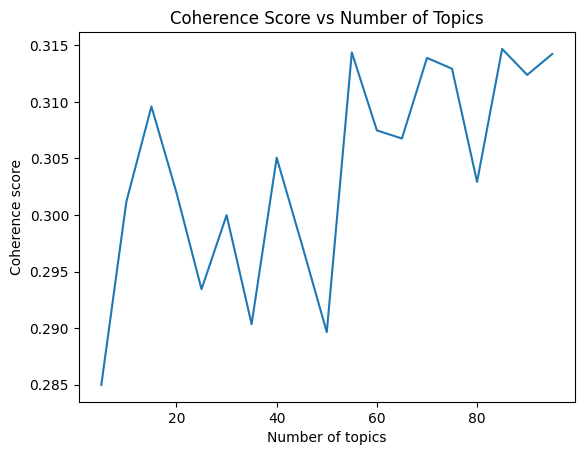

Optimal number of topics: 85
Topic 0: 0.036*"school" + 0.022*"youth" + 0.016*"physical_activity" + 0.013*"program" + 0.010*"intervention" + 0.009*"environment" + 0.008*"mental_health" + 0.007*"child" + 0.006*"impact" + 0.006*"result"
Topic 1: 0.041*"sex_worker" + 0.022*"peer" + 0.015*"risk" + 0.015*"virus" + 0.012*"vaccination" + 0.011*"work" + 0.010*"canada" + 0.009*"variant" + 0.008*"chemical" + 0.007*"woman"
Topic 2: 0.017*"type_diabetes" + 0.016*"app" + 0.015*"stroke" + 0.014*"aging" + 0.011*"medication" + 0.011*"arm" + 0.009*"intervention" + 0.008*"user" + 0.007*"successful_aging" + 0.007*"potential"
Topic 3: 0.031*"father" + 0.023*"mental_health" + 0.021*"asian" + 0.016*"expectation" + 0.014*"parenting" + 0.014*"suicidal_thought" + 0.013*"china" + 0.009*"psychological_problem" + 0.008*"child" + 0.008*"instruction"
Topic 4: 0.013*"people" + 0.013*"community" + 0.007*"intervention" + 0.007*"project" + 0.007*"hiv" + 0.006*"msm" + 0.006*"need" + 0.006*"work" + 0.005*"group" + 0.005*"

In [ ]:
topic_num = range(5, 25, 5)
coherence_score = []

### Evaluating coherence score for each number of topics
for num in topic_num:
    lda_model = LdaModel(corpus = bow_corpus, num_topics=num, id2word=dictionary,
                         random_state=42)
    coherence_model = CoherenceModel(model=lda_model, corpus=bow_corpus,
                                     texts=grants['tokenized_bigrams'], dictionary=dictionary, coherence='c_v')
    coherence_score.append(coherence_model.get_coherence())

### Plotting the coherence scores
plt.plot(topic_num, coherence_score)
plt.xlabel('Number of topics')
plt.ylabel('Coherence score')
plt.title('Coherence Score vs Number of Topics')
plt.show()

### Choose the optimal number of topics
optimal_topics = topic_num[coherence_score.index(max(coherence_score))]
print('Optimal number of topics:', optimal_topics)

for idx, topic in lda_model.print_topics(-1):
    print(f"Topic {idx}: {topic}")


### LDA modeling
lda_model = LdaModel(bow_corpus, num_topics=optimal_topics, id2word=dictionary, random_state=42)
topic_distributions = [dict(lda_model.get_document_topics(bow)) for bow in bow_corpus]
topic_df = pd.DataFrame.from_records(topic_distributions).fillna(0)
topic_df.columns = [f"Topic_{i+1}" for i in range(optimal_topics)]
topic_df.index = grants.index
topic_df = topic_df.sort_index()
grants = grants.sort_index()
topic_df['Grant_Amount'] = grants['log_CIHR_Contribution']
### Categorizing the grant amount
labels = ['Very Small','Small', 'Moderate', 'Large', 'Very Large']
bins = [topic_df['Grant_Amount'].min(), 
        topic_df['Grant_Amount'].quantile(0.2), 
        topic_df['Grant_Amount'].quantile(0.4), 
        topic_df['Grant_Amount'].quantile(0.6), 
        topic_df['Grant_Amount'].quantile(0.8), 
        topic_df['Grant_Amount'].max()]


topic_df['funding_category'] = pd.cut(topic_df['Grant_Amount'], bins=bins, labels=labels, include_lowest=True)
category_order = {"Very Small": 1, "Small": 2, "Moderate": 3, "Large": 4, "Very Large": 5}
topic_df['funding_category'] = topic_df['funding_category'].map(category_order)

In [ ]:
X = topic_df.drop(['funding_category', 'Grant_Amount'], axis=1)  # Topic proportions as features
y = topic_df['funding_category']  # Target variable
X = X.dropna()  # Removes rows with NaN values
# y = y[X.index]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

from sklearn.preprocessing import StandardScaler

# Initialize scaler
scaler = StandardScaler()

# Apply scaling to relevant features
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [32]:
results = {}
logistic_model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=5000)
knn_model = KNeighborsClassifier()
lda_model = LinearDiscriminantAnalysis()
def train_and_evaluate(model, param_grid=None):
    if param_grid:  # Perform grid search if param_grid is provided
        if model in (logistic_model, knn_model, lda_model):
            grid = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
            grid.fit(X_train_scaled, y_train)
            best_model = grid.best_estimator_
            print(f"Best parameters: {grid.best_params_}")
        else:
            grid = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
            grid.fit(X_train, y_train)
            best_model = grid.best_estimator_
            print(f"Best parameters: {grid.best_params_}")
    else:
        best_model = model.fit(X_train, y_train)
    
    if model in (logistic_model, knn_model, lda_model):
        cv_score = cross_val_score(best_model, X_train_scaled, y_train, cv=5, scoring='accuracy').mean()
        print(f"Cross-validation accuracy: {cv_score:.4f}")
    # Cross-validation score
    else:
        cv_score = cross_val_score(best_model, X_train, y_train, cv=5, scoring='accuracy').mean()
        print(f"Cross-validation accuracy: {cv_score:.4f}")
        
    # Evaluate on test data
    if model in (logistic_model, knn_model, lda_model):
        y_pred = best_model.predict(X_test_scaled)
        print("Classification Report:")
        print(classification_report(y_test, y_pred))
        print("Confusion Matrix:")
        print(confusion_matrix(y_test, y_pred))
    else:
        y_pred = best_model.predict(X_test)
        print("Classification Report:")
        print(classification_report(y_test, y_pred))
        print("Confusion Matrix:")
        print(confusion_matrix(y_test, y_pred))
        
    return best_model, cv_score

# 1. Multinomial Logistic Regression
print("\n1. Multinomial Logistic Regression")
logistic_model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=5000)
logistic_param_grid = {'C': [0.1, 1, 10]}  # Regularization parameter
results['Logistic Regression'] = train_and_evaluate(logistic_model, logistic_param_grid)

# 2. Decision Tree
print("\n2. Decision Tree")
tree_model = DecisionTreeClassifier(random_state=42)
tree_param_grid = {'max_depth': [3, 5, 10], 'min_samples_split': [2, 5, 10]}
results['Decision Tree'] = train_and_evaluate(tree_model, tree_param_grid)

# 3. Random Forest
print("\n3. Random Forest")
rf_model = RandomForestClassifier(random_state=42)
rf_param_grid = {'n_estimators': [100, 200], 'max_depth': [5, 10, 20]}
results['Random Forest'] = train_and_evaluate(rf_model, rf_param_grid)

# 4. Gradient Boosting
print("\n4. Gradient Boosting")
gb_model = GradientBoostingClassifier(random_state=42)
gb_param_grid = {'n_estimators': [100, 200], 'learning_rate': [0.01, 0.1], 'max_depth': [3, 5]}
results['Gradient Boosting'] = train_and_evaluate(gb_model, gb_param_grid)

# 5. Naive Bayes
print("\n5. Naive Bayes")
nb_model = MultinomialNB()
nb_param_grid = {'alpha': [0.1, 1, 10]}  # Smoothing parameter
results['Naive Bayes'] = train_and_evaluate(nb_model, nb_param_grid)

# 6. k-Nearest Neighbors (k-NN)
print("\n6. k-Nearest Neighbors (k-NN)")
knn_model = KNeighborsClassifier()
knn_param_grid = {'n_neighbors': [3, 5, 10], 'weights': ['uniform', 'distance']}
results['k-NN'] = train_and_evaluate(knn_model, knn_param_grid)

# 7. Linear Discriminant Analysis (LDA)
print("\n7. Linear Discriminant Analysis")
lda_model = LinearDiscriminantAnalysis()
lda_param_grid = None  # No hyperparameters to tune for LDA
results['LDA'] = train_and_evaluate(lda_model, lda_param_grid)

# Summary of cross-validation scores
print("\nSummary of Cross-Validation Scores:")
for model_name, (model, score) in results.items():
    print(f"{model_name}: {score:.4f}")


1. Multinomial Logistic Regression


TypeError: '<' not supported between instances of 'float' and 'str'

# 4.0 Sentiment Analysis

## 4.1 Importing Stuff

In [30]:
from afinn import Afinn

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import pandas as pd
import string
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [24]:
# read in the files
grants = pd.read_csv('data/analysis/grantmaster.csv')

## 4.2 Read and Tokenize

In [26]:
# punctuation + lemmatize
stop = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

## notes
### 'use' and 'also' appeared too much in the text
#custom_remove_words = set([
#    'applicable', 'for', 'and', 'nor', 'but', 'or', 'yet', 'so', 
#    'after', 'although', 'because', 'before', 'if', 'until', 'when', 'while', 'where', 'as', 'though', 'unless', 'whether', 'however',
#    'et', 'al', 'u', 'eg', 'ie', 'about', 'above', 'against', 'along', 'among', 'around', 'as', 'at', 'before', 'behind',
#    'below', 'beneath', 'beside', 'between', 'beyond', 'by', 'despite', 'during', 'except', 'for', 'from',
#    'in', 'inside', 'into', 'near', 'of', 'on', 'onto', 'opposite', 'out', 'outside', 'over', 'through', 
#    'throughout', 'to', 'toward', 'under', 'underneath', 'until', 'upon', 'with', 'within', 'without', 'use', 'also'
#])

def clean_text(text):
    cleaned_words = []
    words = text.split()
    for word in words:
        word = word.lower() # lowercase
        word = ''.join(char for char in word if char not in string.punctuation) # removes punctuation
        if word.isdigit():
            continue
        if word and word not in stop: # and word not in custom_remove_words: # removes stopwords and lemmatizes
            cleaned_word = lemmatizer.lemmatize(word)
            cleaned_words.append(cleaned_word)
    return cleaned_words

grants['tokenized_Abstract/Summary'] = grants['Abstract/Summary'].apply(clean_text)
grants = grants[grants['tokenized_Abstract/Summary'].apply(len) >= 5].reset_index(drop=True)

## 4.3 VADER & AFINN Sentiment

In [28]:
grants['tokenized_Abstract/Summary_str'] = grants['tokenized_Abstract/Summary'].apply(lambda x: " ".join(x))

In [ ]:
vader = SentimentIntensityAnalyzer()

grants['vader_scores'] = grants['tokenized_Abstract/Summary_str'].apply(vader.polarity_scores)
grants['negative'] = grants['vader_scores'].apply(lambda x: x['neg'])
grants['neutral'] = grants['vader_scores'].apply(lambda x: x['neu'])
grants['positive'] = grants['vader_scores'].apply(lambda x: x['pos'])

In [31]:
afinn = Afinn()

In [33]:
grants['afinn_scores'] = grants['tokenized_Abstract/Summary_str'].apply(lambda x: afinn.score(x))

### 4.3.1 Merge grantmaster_expanded.csv from Unu's Analysis to Normalize AFINN scores

In [34]:
grants_expanded = pd.read_csv('data/analysis/grantmaster_expanded.csv')

In [35]:
merged_df = pd.merge(
    grants,
    grants_expanded,
    left_index=True,  # Use the index to align rows
    right_index=True,  # Ensures corresponding rows are matched
    how='outer',       # Keeps all data from both DataFrames
)

In [36]:
merged_df = merged_df.drop(['Term_Years_y', 'Year_y', 'Grant_Amount'], axis=1)

In [37]:
merged_df['afinn_scores_normalized'] = merged_df['afinn_scores']/merged_df['abstract_length']

In [38]:
merged_df.to_csv('data/analysis/grantmaster2.csv', index=False)

# 5.0 Models

## 5.1 Importing Stuff

In [1]:
import pandas as pd

In [3]:
# read in the files
grants = pd.read_csv('data/analysis/grantmaster2.csv')

## 5.2 Model Set Up

In [ ]:
x = grants.drop(['funding_category', 'Grant_Amount'], axis = 1)
y = grants['funding_category']
X_train, X_test, y_train, y_test = train_test_split(x, y,  test_size=0.2, random_state=42)

from sklearn.preprocessing import StandardScaler

# Initialize scaler
scaler = StandardScaler()

# Apply scaling to relevant features
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)